In [291]:
from matplotlib import pyplot
import numpy
from scipy.linalg import solve_triangular

### General Form of a Gaussian

$p(x) = \exp(-\frac{1}{2}x^\top\Lambda x + x^\top\nu - \ln Z)$

with $\ln Z = \frac{1}{2}\nu^\top\Lambda^{-1}\nu + \frac{D}{2}\ln 2\pi + \frac{1}{2}\ln\det(\Lambda^{-1})$.

### Relation to covariance and mean

$\Sigma = \Lambda^{-1}$

$\mu = \Sigma\nu$

### Form of unnormalised Gaussians

$u(x) = \exp(-\frac{1}{2}x^\top\Lambda x + x^\top\nu + \ln \beta)$

And the intergal is

$\int u(x) d x = \beta Z$

### List of intergals

In [1147]:
class SquaredExponential:
    
    def __init__(self, Lambda: numpy.ndarray, nu: numpy.ndarray=None, ln_beta: numpy.ndarray=None):
        """ A general term, which can be added to a Gaussian.
        
        u(x) = beta * exp(- 0.5 * x'Lambda x + x'nu),
    
        D is the dimension, and R the number of Gaussians.

        :param Lambda: numpy.ndarray [R, D, D]
            Information (precision) matrix of the Gaussian distributions.
        :param nu: numpy.ndarray [R, D]
            Information vector of a Gaussian distribution. If None all zeros. (Default=None)
        :param ln_beta: numpy.ndarray [R]
            The log constant factor of the squared exponential. If None all zeros. (Default=None)
        """
        
        self.Lambda = Lambda
        self.R, self.D = self.Lambda.shape[0], self.Lambda.shape[1]
        if nu is None:
            self.nu = numpy.zeros((self.R, self.D))
        else:
            self.nu = nu
        if ln_beta is None:
            self.ln_beta = numpy.zeros((self.R))
        else:
            self.ln_beta = ln_beta
        self.Sigma = None
        self.ln_det_Lambda = None
        self.ln_det_Sigma = None
        self.lnZ = None
        self.mu = None
        
        
    def compute_lnZ(self):
        """ Computes the log partition function.
        """
        if self.ln_det_Sigma is None:
            self.invert_lambda()
        nu_Lambda_nu = numpy.einsum('rd,rd->r', numpy.einsum('rdd,rd->rd', self.Sigma[r], self.nu), self.nu)
        self.lnZ = .5 * (nu_Lambda_nu + self.D * numpy.log(2. * numpy.pi) + self.ln_det_Sigma)
            
        
    def evaluate_ln(self, x: numpy.ndarray, r: list=[]):
        """ Evaluates the log-exponential term at x.
        
        :param x: numpy.ndarray [N, D]
            Points where the squared exponential should be evaluated.
        :param r: list
            Indices of densities that need to be evaluated. If empty, all densities are evaluated. (Default=[])
            
        :return: numpy.ndarray [N, R] or [N, len(r)]
            Log exponential term.
        """
        if len(r) == 0:
            r = range(self.R)
        x_Lambda_x = numpy.einsum('nrd,nd->nr', numpy.einsum('rdd,nd->nrd', self.Lambda[r], x), x)
        x_nu = numpy.dot(x, self.nu[r].T)
        return - .5 * x_Lambda_x + x_nu + self.ln_beta[r]
    
    def evaluate(self, x: numpy.ndarray, r: list=[]):
        """ Evaluates the exponential term at x.
        
        :param x: numpy.ndarray [N, D]
            Points where the squared exponential should be evaluated.
        :param r: list
            Indices of densities that need to be evaluated. If empty, all densities are evaluated. (Default=[])
            
        :return: numpy.ndarray [N, R] or [N, len(r)]
            Exponential term.
        """
        return numpy.exp(self.evaluate_ln(x, r))
    
    def invert_lambda(self):
        self.Sigma, self.ln_det_Lambda = self.invert_matrix(self.Lambda)
        self.ln_det_Sigma = -self.ln_det_Lambda
                    
    @staticmethod
    def invert_matrix(A):
        L = numpy.linalg.cholesky(A)
        # TODO: Check whether we can make it mor efficienty with solve_triangular.
        #L_inv = solve_triangular(L, numpy.eye(L.shape[0]), lower=True,
        #                         check_finite=False)
        L_inv = numpy.linalg.solve(L, numpy.eye(L.shape[1])[None])
        A_inv = numpy.einsum('rdl,rld->rdl', L_inv, L_inv)
        ln_det_A = 2 * numpy.sum(numpy.log(L.diagonal(axis1=1, axis2=2)), axis=1)
        return A_inv, ln_det_A
    
    def multiply_squared_exponential(self, factor: SquaredExponential, r: list=[]):
        """ Multiplies an exponential factor with another one.
        
        u_1(x) * u_2(x)
        
        :param factor: SquaredExponential
            Factor the object is multiplied with. The number of Gaussians in the resulting object are R * factor.R
        :param r: list
            Indices of densities that need to be evaluated. If empty, all densities are evaluated. (Default=[])
        
        :return: SquaredExponential
            The resulting object.
        """
        if len(r) == 0:
            r = range(self.R)
        R = len(r)
        Lambda = (self.Lambda[r,None] + factor.Lambda[None]).reshape((R * factor.R, self.D, self.D))
        nu = (self.nu[r,None] + factor.nu[None]).reshape((R * factor.R, self.D))
        ln_beta = (self.ln_beta[r,None] + factor.ln_beta[None]).reshape((R * factor.R))
        product = SquaredExponential(Lambda=Lambda, nu=nu, ln_beta=ln_beta)
        return product
    
    def multiply_rank_one(self, U: numpy.ndarray, G: numpy.ndarray, nu: numpy.ndarray=None, ln_beta: numpy.ndarray=None, r: list=[]):
        """ Multiplies the exponential term with another exponential term, where the Lambda is rank 1, i.e.
        
        Lambda = U G U'
            
        Where G is an [1 x 1] diagonal matrix and U and [D x 1] with a vector. If already computed, the covariance matrix Sigma and its log-determinant are efficiently updated.
        
        :param U: numpy.ndarray [R1, D]
            Vector of low rank matrix with orthogonal vectors.
        :param G: numpy.ndarray [R1]
            Diagonal entries of the low-rank matrix.
        :param nu: numpy.ndarray [R1, D]
            Information vector of the low rank part. If None all entries are zero. (Default=None)
        :param nu: numpy.ndarray [R1]
            Log factor of the low rank part. If None all entries are zero. (Default=None)
        :param r: list
            Indices of densities that need to be evaluated. If empty, all densities are evaluated. (Default=[])
            
        :return: Squared exponential
            The resulting product, where the number of Gaussians is self.R * R1.
        """
        if len(r) == 0:
            r = range(self.R)
        R = len(r)
        R1 = G.shape[0]
        UGU = numpy.einsum('rd,rs->rds', U, G[:,None] * U)
        Lambda_new = (self.Lambda[r,None] + UGU[None]).reshape((R * R1, self.D, self.D))
        if nu is None:
            nu_new = numpy.tile(self.nu, (R1, 1))
        else:
            nu_new = (self.nu[r,None] + nu[None]).reshape((R * R1, self.D))
        if ln_beta is None:
            ln_beta_new = numpy.tile(self.ln_beta, (R1))
        else:
            ln_beta_new = (self.ln_beta[r,None] + ln_beta[None]).reshape((R * R1))
        print(nu_new)
        product = SquaredExponential(Lambda=Lambda_new, nu=nu_new, ln_beta=ln_beta_new)
        
        # if the Sigma of the object is known the Sherman-morrison formula and the matrix determinant lemma are used for efficient update of the inverses and the log determinants.
        if self.Sigma is not None and self.ln_det_Sigma is not None:
            # Sherman morrison inversion
            G_inv = 1. / G
            Sigma_U = numpy.einsum('rsdd,rsd->rsd', self.Sigma[r,None], U[None])
            U_Sigma_U = numpy.einsum('rsd,rsd->rs', Sigma_U, U[None])
            denominator = 1. + G[None] * U_Sigma_U
            nominator = G[None] * numpy.einsum('rsd,rsk->rsdk', Sigma_U, Sigma_U)
            Sigma_new = self.Sigma[r, None] - nominator / denominator[:,:,None,None]
            product.Sigma = Sigma_new.reshape((R*R1, self.D, self.D))
            # Matrix determinant lemma
            ln_det_Sigma_new = self.ln_det_Sigma[r,None] - numpy.log(denominator)
            product.ln_det_Sigma = ln_det_Sigma_new.reshape((R * R1))
            product.ln_det_Lambda = -product.ln_det_Sigma
        return product
    
    def log_integral(self):
        """ Computes the log integral of the exponential term.
        
        log \int u(x) dx.
        
        :return: numpy.ndarray [R]
            Log integral
        """
        self._prepare_inegration()
        return self.lnZ + self.ln_beta
    
    def integral(self):
        """ Computes the log integral of the exponential term.
        
        \int u(x) dx.
        
        :return: numpy.ndarray [R]
            Integral
        """
        return numpy.exp(self.log_integral())
    
    def normalize(self):
        """ Normalizes the term such that
        
        int u(x) dx = 1.
        """
        self.ln_beta = -self.log_integral()
        
    def is_normalized(self):
        return numpy.equal(self.lnZ, -self.ln_beta)
    
    def compute_mu(self):
        """ Converts from information to mean vector.
        
        :return: numpy.ndarray [R, D]
            Mean vector.
        """
        if self.Sigma is None:
            self.invert_lambda()
        self.mu = numpy.einsum('rdd,rd->rd', self.Sigma, self.nu)
    
    def get_density(self):
        """ Returns the corresponing normalised density object.
        
        :return: GaussianDensity
            Corresponding density object.
        """
        self._prepare_inegration()
        return GaussianDensity(Sigma=self.Sigma, mu=mu, Lambda=self.Lambda, ln_det_Sigma=self.ln_det_Sigma)
    
    def _prepare_inegration(self):
        if self.lnZ is None:
            self.compute_lnZ()
        if self.mu is None:
            self.compute_mu()
            
    def _expectation_x(self):
        """ Computes the expectation.
        
            int x du(x) / int du(x)
        
        :return: numpy.ndarray [R, D]
            The solved intergal.
        """
        return self.mu 
            
    def intergrate_x(self):
        """ Computes the integral.
        
            int x du(x)
        
        :return: numpy.ndarray [R, D]
            The solved intergal.
        """
        constant = self.integral()
        return constant[:,None] * self._expectation_x()
    
    def _expectation_xx(self):
        """ Computes the expectation.
        
            int xx' du(x) / int du(x)
        
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        return self.Sigma + numpy.einsum('ab,ac->abc', self.mu, self.mu)
    
    def intergrate_xx(self):
        """ Computes the integral.
        
            int xx' du(x)
        
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        constant = self.integral()
        return constant[:,None,None] * self._expectation_xx()
    
    def _expectation_xbxx(self, b: numpy.ndarray):
        """ Computes the cubic expectation.
        
            int xb'xx' du(x)
        :param b: numpy.ndarray [D,]
            Vector of 
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        constant = self.integral()
        Exx = self._expectation_xx()
        bmu_outer = numpy.einsum('a,bc->bac', b, self.mu)
        bmu_inner = numpy.dot(self.mu, b)
        print(bmu_inner.shape)
        mbExx = numpy.einsum('abc,ade->abe', Exx, bmu_outer)
        Exx_m = self.Sigma - numpy.einsum('ab,ac->abc', self.mu, self.mu)
        return mbExx + numpy.swapaxes(mbExx, 1, 2) + bmu_inner[:,None,None] * Exx_m
    
    def intergate_xbxx(self, b: numpy.ndarray):
        """ Computes the cubic integral.
        
            int xb'xx' du(x)
        :param b: numpy.ndarray [D,]
            Vector of 
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        constant = self.integral()
        return constant[:,None,None] * self._expectation_xbxx(b)

    
class DiagonalSquaredExponential(SquaredExponential):
    
    def invert_lambda(self):
        self.Sigma = numpy.diag(self.Lambda.diagonal())
        self.ln_det_Lambda = numpy.sum(numpy.log(self.Lambda.diagonal()))
        self.ln_det_Sigma = -self.ln_det_Lambda   
    
class GaussianDensity(SquaredExponential):
    
    def __init__(self, Sigma: numpy.ndarray, mu: numpy.ndarray, Lambda: numpy.ndarray=None, ln_det_Sigma: numpy.ndarray=None):
        """ A normalized Gaussian density, with specified mean and covariance matrix.
        
        :param Sigma: numpy.ndarray [R, D, D]
            Covariance matrices of the Gaussian densities.
        :param mu: numpy.ndarray [R, D]
            Mean of the Gaussians.
        :param Lambda: numpy.ndarray [R, D, D] or None
            Information (precision) matrix of the Gaussians. (Default=None)
        :param ln_det_Sigma: numpy.ndarray [R] or None
            Log determinant of the covariance matrix. (Default=None)
        """
        if Lambda is None:
            Lambda, ln_det_Sigma = self.invert_matrix(Sigma)
        elif ln_det_Sigma is None:
            ln_det_Sigma = numpy.linalg.slogdet(Sigma)[1]
        nu = numpy.einsum('rsd,rd->rd', Lambda, mu)
        super().__init__(Lambda=Lambda, nu=nu)
        self.Sigma = Sigma
        self.ln_det_Sigma = ln_det_Sigma
        self.ln_det_Lambda = -ln_det_Sigma
        self.normalize()
        
    def sample(self, num_samples: int):
        L = numpy.linalg.cholesky(self.Sigma)
        rand_nums = numpy.random.randn(num_samples, self.R, self.D)
        x_samples = self.mu[None] + numpy.einsum('rdd,nrd->nrd', L, rand_nums)
        return x_samples
                                       
class SphericalGaussianDensity(GaussianDensity):
    
    def __init__(self, Sigma: numpy.ndarray, mu: numpy.ndarray, Lambda: numpy.ndarray=None, ln_det_Sigma: numpy.ndarray=None):
        """ A normalized Gaussian density, with specified mean and covariance matrix.
        
        :param Sigma: numpy.ndarray [R, D, D]
            Covariance matrices of the Gaussian densities.
        :param mu: numpy.ndarray [R, D]
            Mean of the Gaussians.
        :param Lambda: numpy.ndarray [R, D, D] or None
            Information (precision) matrix of the Gaussians. (Default=None)
        :param ln_det_Sigma: numpy.ndarray [R] or None
            Log determinant of the covariance matrix. (Default=None)
        """
        if Lambda is None:
            Lambda = numpy.diag(Sigma.diagonal())
            ln_det_Sigma = numpy.sum(numpy.log(Sigma.diagonal()))
        elif ln_det_Sigma is None:
            ln_det_Sigma = numpy.sum(numpy.log(Sigma.diagonal()))
        nu = numpy.einsum('rsd,rd->rd', Lambda, mu)
        super().__init__(Lambda=Lambda, nu=nu)
        self.Sigma = Sigma
        self.ln_det_Sigma = ln_det_Sigma
        self.ln_det_Lambda = -ln_det_Sigma
        self.mu = mu
        self.normalize()

In [1148]:
numpy.diag(numpy.eye(4).diagonal())

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

### Test for 1 D

In [1149]:
R, D, R1 = 2, 1, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * (rand_nums + rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

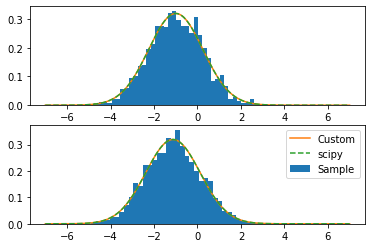

In [1150]:
from scipy.stats import norm

xrange = numpy.linspace(-7,7,1000)
for ir in range(R):
    pyplot.subplot(R, 1, ir+1)
    scipy_gauss = norm.pdf(xrange, loc=mu_phi[ir], scale=numpy.sqrt(Sigma_phi[ir,0,0]))
    pyplot.hist(phi.sample(2000)[:,ir], bins=40, density=True, label='Sample')
    pyplot.plot(xrange, phi.evaluate(numpy.array([xrange]).T)[:,ir], label='Custom')
    pyplot.plot(xrange, scipy_gauss, '--', label='scipy')
pyplot.legend()
pyplot.show()

### Test for integral x

In [1151]:
R, D, R1 = 10, 1, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

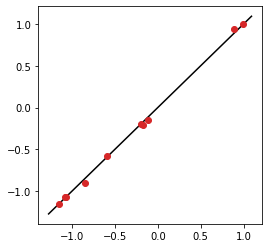

In [1152]:
x_sample = numpy.mean(phi.sample(2000), axis=0)
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)], [1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)] ,'k')
pyplot.plot(x_sample, phi.intergrate_x()[:,0], 'C3o')

In [1153]:
R, D, R1 = 10, 2, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

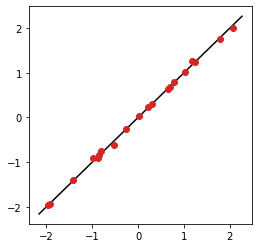

In [1154]:
x_sample = numpy.mean(phi.sample(2000), axis=0)
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)], [1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)] ,'k')
pyplot.plot(x_sample.flatten(), phi.intergrate_x().flatten(), 'C3o')

### Test for intergal xx

In [1155]:
R, D, R1 = 10, 3, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

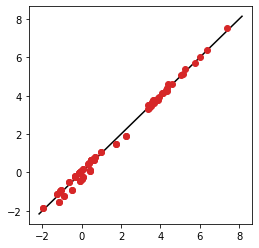

In [1156]:
x_sample = phi.sample(10000)
x2_sample = numpy.mean(x_sample[:,:,None] * x_sample[:,:,:,None], axis=0)
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(x2_sample), 1.1 * numpy.amax(x2_sample)], [1.1 * numpy.amin(x2_sample), 1.1 * numpy.amax(x2_sample)] ,'k')
pyplot.plot(x2_sample.flatten(), phi.intergrate_xx().flatten(), 'C3o')

### Test for intergal xbxx

In [1168]:
R, D, R1 = 1, 4, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

In [1169]:
b = numpy.random.randn(D)

In [1170]:
(x_sample[:,:,:,None] * numpy.sum((b * x_sample[:,:,None] * x_sample[:,:,:,None]), axis=3)[:,:,None]).shape

(10000, 1, 4, 4)

(1,)


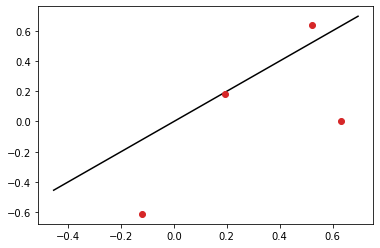

In [1180]:
i = 0
x_sample = phi.sample(10000)
xbxx_sample = numpy.mean(x_sample[:,:,:,None] * numpy.sum((b * x_sample[:,:,:,None] * x_sample[:,:,None]), axis=)[:,:,None], axis=0)
#xbxx_sample = numpy.mean(b * x_sample ** 3, axis=0)
pyplot.plot([1.1 * numpy.amin(xbxx_sample), 1.1 * numpy.amax(xbxx_sample)], [1.1 * numpy.amin(xbxx_sample), 1.1 * numpy.amax(xbxx_sample)] ,'k')
pyplot.plot(xbxx_sample[i].diagonal().flatten(), phi.intergate_xbxx(b)[i].diagonal().flatten(), 'C3o')

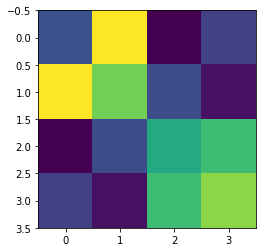

In [1178]:
pyplot.imshow(xbxx_sample[i])

(1,)


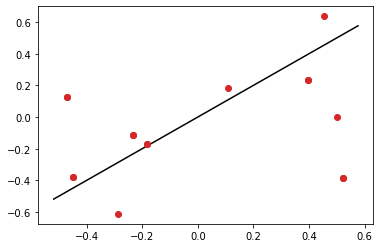

In [1176]:
pyplot.plot([1.1 * numpy.amin(xbxx_sample), 1.1 * numpy.amax(xbxx_sample)], [1.1 * numpy.amin(xbxx_sample), 1.1 * numpy.amax(xbxx_sample)] ,'k')
pyplot.plot(xbxx_sample.flatten(), phi.intergate_xbxx(b).flatten(), 'C3o')

In [1132]:
phi.intergate_xbxx(b)

(1,)


array([[[ 0.33062644, -0.02813768,  0.30089092,  0.44514169],
        [-0.02813768, -0.11849511, -0.10753539,  0.00627576],
        [ 0.30089092, -0.10753539,  0.21830598,  0.43503418],
        [ 0.44514169,  0.00627576,  0.43503418,  0.58318958]]])

In [513]:
phi.Lambda[1], phi.Sigma[1]

(array([[1.03604571]]), array([[0.96520838]]))

In [514]:
.5*(phi.Lambda[0] * phi.nu[0] ** 2 + phi.D * numpy.log(2. * numpy.pi) + phi.ln_det_Sigma[0])

array([[1.71523847]])

In [515]:
phi.Lambda[0] * phi.nu[0] ** 2 

array([[1.62801114]])

In [516]:
phi.lnZ

array([1.71523847, 1.5602542 , 1.20196851, 0.97380229, 2.71252378,
       1.72198793, 0.90663407, 0.93210505, 0.90163223, 0.90140234])

In [517]:
numpy.sum(phi.evaluate(numpy.array([xrange]).T)[:,0]) * (xrange[1] - xrange[0])

0.9458646152974386

In [396]:
phi.evaluate(numpy.array([xrange]).T)[:,0]

array([1.26089660e-02, 1.45538430e-02, 1.67284052e-02, 1.91474099e-02,
       2.18244936e-02, 2.47717653e-02, 2.79993778e-02, 3.15150823e-02,
       3.53237787e-02, 3.94270702e-02, 4.38228380e-02, 4.85048466e-02,
       5.34623955e-02, 5.86800311e-02, 6.41373333e-02, 6.98087891e-02,
       7.56637659e-02, 8.16665941e-02, 8.77767662e-02, 9.39492575e-02,
       1.00134970e-01, 1.06281293e-01, 1.12332787e-01, 1.18231957e-01,
       1.23920132e-01, 1.29338404e-01, 1.34428629e-01, 1.39134453e-01,
       1.43402342e-01, 1.47182591e-01, 1.50430287e-01, 1.53106197e-01,
       1.55177552e-01, 1.56618719e-01, 1.57411725e-01, 1.57546636e-01,
       1.57021757e-01, 1.55843671e-01, 1.54027105e-01, 1.51594616e-01,
       1.48576131e-01, 1.45008331e-01, 1.40933911e-01, 1.36400732e-01,
       1.31460880e-01, 1.26169684e-01, 1.20584680e-01, 1.14764588e-01,
       1.08768292e-01, 1.02653877e-01, 9.64777235e-02, 9.02936857e-02,
       8.41523711e-02, 7.81005290e-02, 7.21805583e-02, 6.64301358e-02,
      

In [395]:
numpy.array([xrange]).shape

(1, 100)

In [374]:
w = .1 * numpy.random.randn(R1, D)
g = numpy.random.rand(R1)
nu1 = numpy.random.randn(R1, D)
expw_phi = phi.multiply_rank_one(w, g, nu1)

[[ 0.96891079 -0.08849242 -2.33876849 -0.42035256 -0.20083232]
 [ 0.9864387  -0.39891435 -2.78846947 -1.00197272 -0.30150384]
 [ 0.66524096 -0.03742665 -2.6680618  -0.65977377 -0.21573154]
 [ 0.91403438 -0.13595734 -2.6854188  -0.60651131 -0.38914833]
 [ 0.7856387  -0.30573508 -2.413627   -0.08636799 -0.47983104]
 [ 0.87878025 -0.26966957 -2.56981099 -0.6431554  -0.46750354]
 [ 1.01917318 -0.06316189 -2.35460795 -0.72038873  0.32372495]
 [ 1.00322201 -0.44263976 -2.52757283 -0.15881234 -0.17627003]
 [ 0.94905425 -0.45145128 -2.6820193  -0.47296907 -0.44977522]
 [ 0.98472463 -0.02388192 -2.5348156  -0.59767289 -0.31862887]]


In [375]:
expw_phi.compute_lnZ()

In [376]:
expw_phi.log_integral()

array([3.16838431, 4.74770949, 3.85438084, 4.19726682, 3.17001647,
       3.93728073, 3.19397002, 3.61274917, 4.23497607, 3.81973572])

In [283]:
N, R, D = 100, 10, 5
x = numpy.random.randn(N, D)
Lambda = numpy.tile(numpy.eye(D), (R,1,1))
Lambda[0] *= 2
#Lambda = numpy.random.randn(R, D, D)
#Lambda += numpy.swapaxes(Lambda, 1, 2)
#Lambda += D * numpy.eye(D)
nu = numpy.random.randn(R, D)
ln_beta = numpy.random.randn(R)
r = [0]
mu = numpy.zeros((R,D))

In [284]:
numpy.tile(numpy.random.randn(10,1), (10,1)).shape

(100, 1)

In [267]:
se = SquaredExponential(Lambda, nu, ln_beta)

In [268]:
gauss = GaussianDensity(Lambda, mu)

In [270]:
se.multiply_squared_exponential(gauss)

In [202]:
se_new = se.multiply_squared_exponential(se)

In [ ]:
mu
GaussianDensity(Lambda, mu)

In [150]:
A = Lambda
L = numpy.linalg.cholesky(A)
#L_inv = solve_triangular(L, numpy.eye(L.shape[0]), lower=True,
#                         check_finite=False)
L_inv = numpy.linalg.solve(L, numpy.eye(L.shape[1])[None])
A_inv = numpy.einsum('rdl,rld->rdl', L_inv, L_inv)
log_det_A = 2 * numpy.sum(numpy.log(L.diagonal(axis1=1, axis2=2)), axis=1)

In [156]:
numpy.meshgrid(range(10), range(10))[0][0]#.flatten()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [64]:
numpy.einsum('nrd,nd->nr', numpy.einsum('rdd,nd->nrd', Lambda, x), x)

array([[-4.00069280e+00,  2.39287124e+00, -1.71223610e+00,
        -3.20437653e+00,  6.61580801e+00,  6.02093273e-02,
        -3.22649087e+00,  3.22008267e+00, -9.90007757e-01,
        -2.38548497e-01],
       [ 4.06875771e-01,  1.25385831e+00, -1.23891867e-01,
        -3.34191929e-01,  2.31323420e+00,  1.38548317e-01,
        -9.81409614e-01,  9.77013271e-01,  1.57164047e-01,
         6.58698513e-01],
       [ 7.02741009e-01, -2.81862673e-01,  3.03309918e+00,
        -1.17818251e+00,  5.26805040e+00, -3.52579504e+00,
         7.04281873e-01, -3.06636950e+00, -7.01321384e-01,
        -1.09703120e+00],
       [-4.18887193e+00, -3.03037028e+00,  2.41048827e+00,
        -3.20661150e+00,  3.18660377e+00, -5.54026697e+00,
         2.00225852e+00, -4.49374004e+00, -2.11870063e+00,
        -2.07165600e+00],
       [ 2.08871907e+00,  2.37735887e+00,  6.43632277e-01,
        -9.32393029e-01,  5.44763418e+00, -1.15068221e+00,
        -1.60956815e+00,  1.00112264e+00,  6.06990025e-01,
         2.

In [62]:
numpy.sum(Lambda[None] * x[:,None,:,None], axis=2) == numpy.einsum('rdi,nd->nri', Lambda, x)

array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        ...,
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        ...,
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        ...,
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       ...,

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True